<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/Routin_Wavelength_Assignment_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ortools
from ortools.sat.python import cp_model # CP-SAT solver
import numpy as np
from random import randint
import random
from math import ceil
import pandas as pd
import matplotlib.pyplot as plt # Data visualization
import networkx as nx
from google.colab import drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 897.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.3 which is incompatible.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.

In [2]:
KOLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
            "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
            "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
            "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
            "#8c6d31", "#9c9ede", "#637939", "#e7cb94", "#b5cf6b",
            "#cedb9c", "#c7c7c7", "#bd9e39", "#e7969c", "#7b4173"]

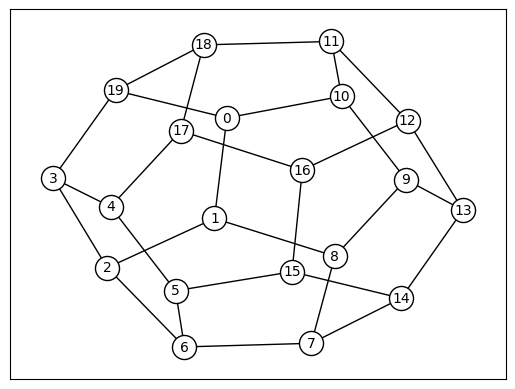

In [3]:
n = 14  # 10 nodes
m = 20  # 20 edges
seed = 216  # seed random number generators for reproducibility

# Use seed for reproducibility

G=nx.Graph()
G.add_nodes_from(range(2))
G.add_edges_from([(0,1)])
pos = nx.spring_layout(G, seed=14)


G = nx.dodecahedral_graph()
pos = nx.spring_layout(G, seed=14)


options = {
    "font_size": 10,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}
nx.draw_networkx(G, pos, **options)
plt.show()

In [4]:
df = pd.DataFrame()
N = len(pos)

connect = {}
for (i,j) in G.edges:
  connect[(i,j)] = 1
  connect[(j,i)] = 1

nodes = [n for n in G.nodes()]
df['X'] = [pos[n][0] for n in nodes]
df['Y'] = [pos[n][1] for n in nodes]

def dist(i,j,df):
  x1,y1 = df.loc[i,'X'],df.loc[i,'Y']
  x2,y2 = df.loc[j,'X'],df.loc[j,'Y']
  return int(1000*np.sqrt( (x1-x2)**2 +(y1-y2)**2))


In [5]:
demands = {0:[4,8], 1:[6,5], 2:[2,5], 3:[0,9], 4:[2,3]}
demands = {0:[3,8], 1:[6,9], 2:[1,5], 3:[0,5], 4:[3,7], 5:[9,7]}
demands = {l:random.sample(nodes,2) for l in range(8)}

In [6]:
demands

{0: [19, 10],
 1: [12, 15],
 2: [1, 14],
 3: [16, 10],
 4: [3, 11],
 5: [11, 12],
 6: [15, 10],
 7: [3, 11]}

In [7]:
model = cp_model.CpModel()
solver = cp_model.CpSolver()
wl_set = range(3)
lambdas = {(l,wl):model.NewBoolVar(f"lambda_{l}_{wl}") for l in demands for wl in wl_set }
U = {(i,j,l):model.NewBoolVar(f"connection_{i}_{j}_{l}")  for (i,j) in connect for l in demands}
select = {(i,l):model.NewBoolVar(f"select_{i}_{l}")  for i in nodes for l in demands}
Z = {(i,j,l1,l2):model.NewBoolVar(f"z_{i}_{j}_{l1}_{l2}")  for (i,j) in connect for l1 in demands for l2 in demands if l1>l2 and i>j}
accepted = {l:model.NewBoolVar(f"accepted_{l}")  for l in demands}


for l in demands:
  aa= [(demands[l][0],demands[l][1],accepted[l])]
  bb = [(i,i,select[i,l].Not()) for i in nodes ]
  cc = [(i,j,v) for (i,j,L),v in U.items() if L ==l]
  model.Add(select[demands[l][0],l]==accepted[l])
  model.Add(select[demands[l][1],l]==accepted[l])
  model.AddCircuit(cc+aa+ bb)


for (i,l),v in select.items():
  model.Add(v<=accepted[l])

for (i,j,l1),v in U.items():
  for (m,n,l2),vv in U.items():
    con1 = (i,j) == (m,n) and l1>l2 and i>j
    if con1:
      model.Add(Z[i,j,l1,l2] <= v + U[j,i,l1])
      model.Add(Z[i,j,l1,l2] <= vv+ U[n,m,l2])
      model.Add(Z[i,j,l1,l2] >= vv + v + U[n,m,l2] + U[j,i,l1] -1)

      model.Add(Z[i,j,l1,l2] <= select[i,l1])
      model.Add(Z[i,j,l1,l2] <= select[j,l1])
      model.Add(Z[i,j,l1,l2] <= select[i,l2])
      model.Add(Z[i,j,l1,l2] <= select[j,l2])




for wl in wl_set:
  for (i,j,l1,l2),v in Z.items():
    model.Add(lambdas[l1,wl] + lambdas[l2,wl]<=2-v)

for l in demands:
  expressions = [lambdas[l,wl] for wl in wl_set]
  model.Add(sum(expressions) == accepted[l])

expressions = [v for l,v in accepted.items() ]
model.Maximize(sum(expressions))

solver.parameters.subsolvers[:] = ['core', 'pseudo_costs', 'no_lp']
solver.parameters.max_time_in_seconds = 90
solver.Solve(model)

#print(f"x", solver.Value(x))
print(solver.StatusName(), solver.ObjectiveValue()  )

for L in demands:
  a = [(i,j) for (i,j,l),v in U.items() if solver.Value(v)>0 and L==l]
  print(demands[L])
  print(L,a)



OPTIMAL 8.0
[19, 10]
0 [(0, 19), (10, 0)]
[12, 15]
1 [(16, 12), (15, 16)]
[1, 14]
2 [(2, 1), (3, 2), (4, 3), (17, 4), (13, 12), (12, 16), (14, 13), (16, 17)]
[16, 10]
3 [(8, 7), (7, 14), (9, 8), (10, 9), (14, 15), (15, 16)]
[3, 11]
4 [(19, 3), (11, 18), (18, 19)]
[11, 12]
5 [(0, 1), (19, 0), (1, 8), (2, 3), (6, 2), (3, 19), (7, 6), (14, 7), (8, 9), (9, 10), (10, 11), (12, 13), (13, 14)]
[15, 10]
6 [(0, 19), (10, 0), (1, 2), (8, 1), (2, 6), (3, 4), (19, 3), (4, 17), (6, 5), (5, 15), (7, 8), (14, 7), (11, 12), (18, 11), (12, 13), (13, 14), (17, 18)]
[3, 11]
7 [(4, 3), (17, 4), (11, 18), (18, 17)]


In [8]:

for l in demands:
  a= [(i,j) for (i,j,L),v in U.items() if solver.value(v)==1 and L ==l]
  b= {i:solver.value(v) for (i,L),v in select.items() if L ==l}
  kk = sum([wl*solver.value(lambdas[l,wl]) for wl in wl_set])
  print(f"Demand {l}","Send/Receive", demands[l],"Wavelength: " , kk,"Route : ", a)
  #print(b)

Demand 0 Send/Receive [19, 10] Wavelength:  1 Route :  [(0, 19), (10, 0)]
Demand 1 Send/Receive [12, 15] Wavelength:  2 Route :  [(16, 12), (15, 16)]
Demand 2 Send/Receive [1, 14] Wavelength:  1 Route :  [(2, 1), (3, 2), (4, 3), (17, 4), (13, 12), (12, 16), (14, 13), (16, 17)]
Demand 3 Send/Receive [16, 10] Wavelength:  1 Route :  [(8, 7), (7, 14), (9, 8), (10, 9), (14, 15), (15, 16)]
Demand 4 Send/Receive [3, 11] Wavelength:  1 Route :  [(19, 3), (11, 18), (18, 19)]
Demand 5 Send/Receive [11, 12] Wavelength:  2 Route :  [(0, 1), (19, 0), (1, 8), (2, 3), (6, 2), (3, 19), (7, 6), (14, 7), (8, 9), (9, 10), (10, 11), (12, 13), (13, 14)]
Demand 6 Send/Receive [15, 10] Wavelength:  0 Route :  [(0, 19), (10, 0), (1, 2), (8, 1), (2, 6), (3, 4), (19, 3), (4, 17), (6, 5), (5, 15), (7, 8), (14, 7), (11, 12), (18, 11), (12, 13), (13, 14), (17, 18)]
Demand 7 Send/Receive [3, 11] Wavelength:  2 Route :  [(4, 3), (17, 4), (11, 18), (18, 17)]


{0: [19, 10], 1: [12, 15], 2: [1, 14], 3: [16, 10], 4: [3, 11], 5: [11, 12], 6: [15, 10], 7: [3, 11]}
(0, 1) [19, 10] final [(0, 19), (10, 0)]


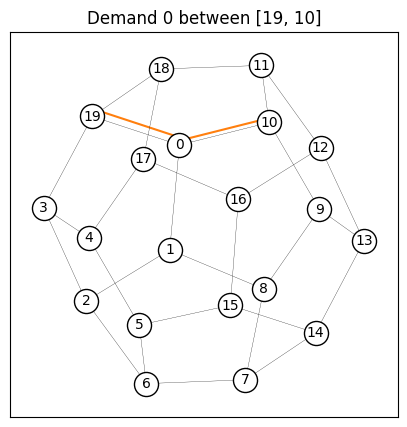

(1, 2) [12, 15] final [(16, 12), (15, 16)]


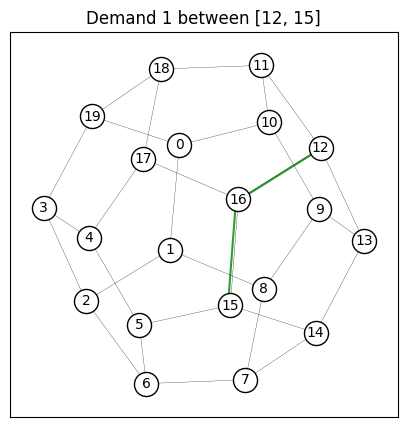

(2, 1) [1, 14] final [(2, 1), (3, 2), (4, 3), (17, 4), (13, 12), (12, 16), (14, 13), (16, 17)]


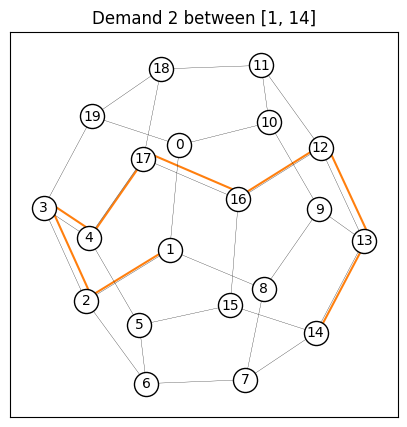

(3, 1) [16, 10] final [(8, 7), (7, 14), (9, 8), (10, 9), (14, 15), (15, 16)]


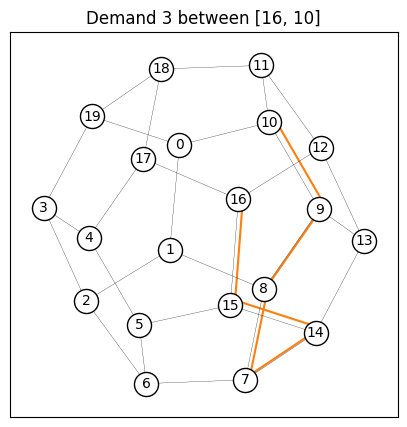

(4, 1) [3, 11] final [(19, 3), (11, 18), (18, 19)]


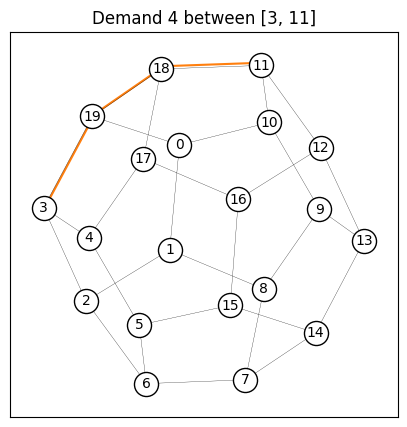

(5, 2) [11, 12] final [(0, 1), (19, 0), (1, 8), (2, 3), (6, 2), (3, 19), (7, 6), (14, 7), (8, 9), (9, 10), (10, 11), (12, 13), (13, 14)]


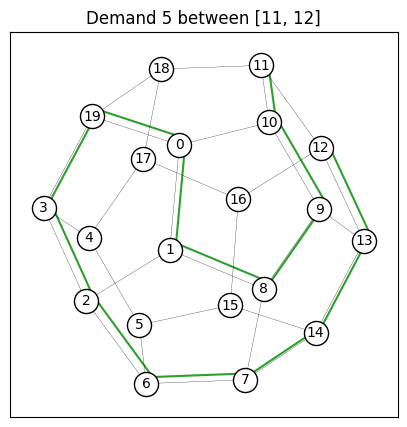

(6, 0) [15, 10] final [(0, 19), (10, 0), (1, 2), (8, 1), (2, 6), (3, 4), (19, 3), (4, 17), (6, 5), (5, 15), (7, 8), (14, 7), (11, 12), (18, 11), (12, 13), (13, 14), (17, 18)]


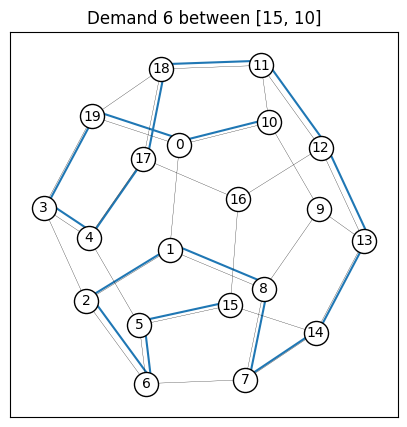

(7, 2) [3, 11] final [(4, 3), (17, 4), (11, 18), (18, 17)]


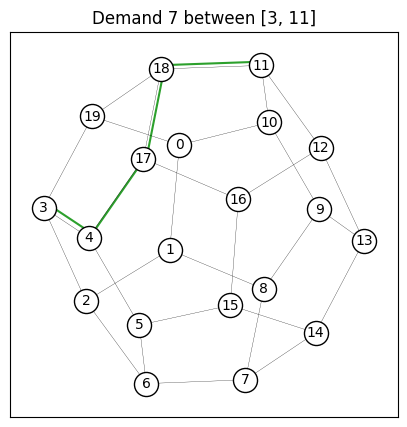

In [9]:
print(demands)
options = {
    "font_size": 10,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 0.2,
}
#folder_path = '/content/drive/My Drive/Colab Notebooks/img'

#plt.scatter(df['X'],df['Y'],s=20)
disp = {l:-0.04+0.08*random.random() for l in demands}
for L in demands:
  if solver.value(accepted[L])>0:

    a= [(i,j) for (i,j,l),v in U.items() if solver.value(v)==1 and L ==l]
    kk = sum([wl*solver.value(lambdas[L,wl]) for wl in wl_set])

    print((L,kk),demands[L],"final", a)

    plt.figure(figsize=(5,5))
    nx.draw_networkx(G, pos, **options)
    for (i,j,l),v in U.items():
      if solver.Value(v)>0 and L==l:
        x1,y1 = df.loc[i,'X']+disp[l],df.loc[i,'Y']+disp[l]
        x2,y2 = df.loc[j,'X']+disp[l],df.loc[j,'Y']+disp[l]
        #kk =l
        plt.plot([x1,x2],[y1,y2], lw= 1.5, c= KOLORS[kk], zorder=-2)
    plt.title(f"Demand {L} between {demands[L]}")
    #plt.savefig(os.path.join(folder_path, f"demand_{L}.png"))

    plt.show()


{0: [19, 10], 1: [12, 15], 2: [1, 14], 3: [16, 10], 4: [3, 11], 5: [11, 12], 6: [15, 10], 7: [3, 11]}
(0, 1) [19, 10] final [(0, 19), (10, 0)]
(1, 2) [12, 15] final [(16, 12), (15, 16)]
(2, 1) [1, 14] final [(2, 1), (3, 2), (4, 3), (17, 4), (13, 12), (12, 16), (14, 13), (16, 17)]
(3, 1) [16, 10] final [(8, 7), (7, 14), (9, 8), (10, 9), (14, 15), (15, 16)]
(4, 1) [3, 11] final [(19, 3), (11, 18), (18, 19)]
(5, 2) [11, 12] final [(0, 1), (19, 0), (1, 8), (2, 3), (6, 2), (3, 19), (7, 6), (14, 7), (8, 9), (9, 10), (10, 11), (12, 13), (13, 14)]
(6, 0) [15, 10] final [(0, 19), (10, 0), (1, 2), (8, 1), (2, 6), (3, 4), (19, 3), (4, 17), (6, 5), (5, 15), (7, 8), (14, 7), (11, 12), (18, 11), (12, 13), (13, 14), (17, 18)]
(7, 2) [3, 11] final [(4, 3), (17, 4), (11, 18), (18, 17)]


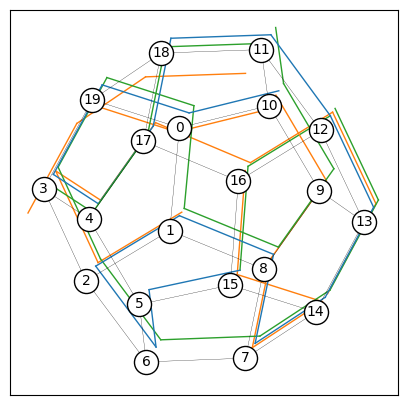

In [10]:
print(demands)
options = {
    "font_size": 10,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 0.2,
}
#folder_path = '/content/drive/My Drive/Colab Notebooks/img'

#plt.scatter(df['X'],df['Y'],s=20)
disp = {l:-0.1+0.2*random.random() for l in demands}
plt.figure(figsize=(5,5))
nx.draw_networkx(G, pos, **options)

for L in demands:
  if solver.value(accepted[L])>0:

    a= [(i,j) for (i,j,l),v in U.items() if solver.value(v)==1 and L ==l]
    kk = sum([wl*solver.value(lambdas[L,wl]) for wl in wl_set])

    print((L,kk),demands[L],"final", a)

    for (i,j,l),v in U.items():
      if solver.Value(v)>0 and L==l:
        x1,y1 = df.loc[i,'X']+disp[l],df.loc[i,'Y']+1.5*disp[l]
        x2,y2 = df.loc[j,'X']+disp[l],df.loc[j,'Y']+1.5*disp[l]
        #kk =l
        plt.plot([x1,x2],[y1,y2], lw= 1, c= KOLORS[kk], zorder=-2)

#plt.savefig(os.path.join(folder_path, f"demand.png"))
